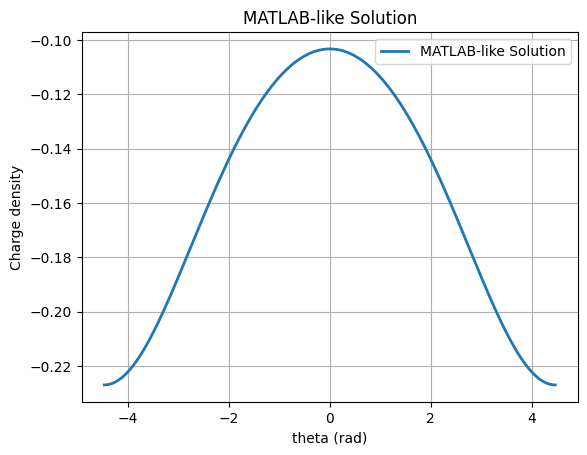

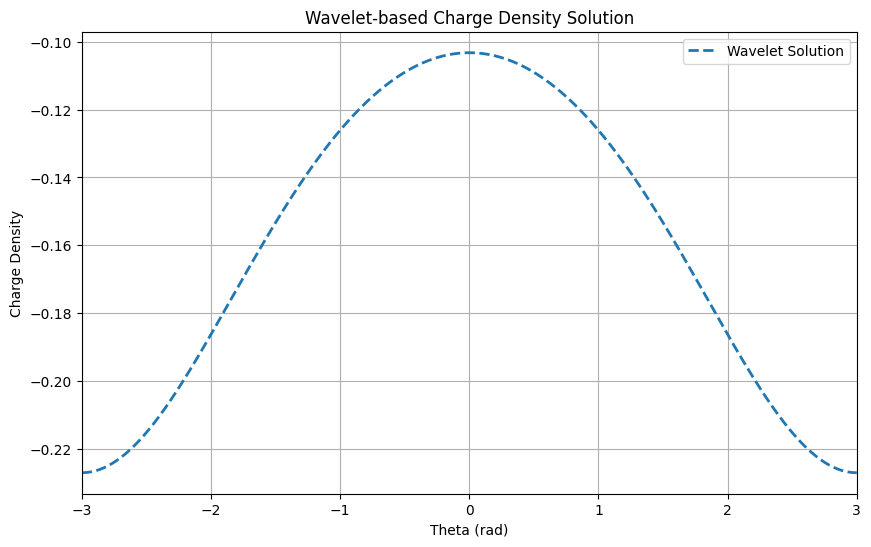

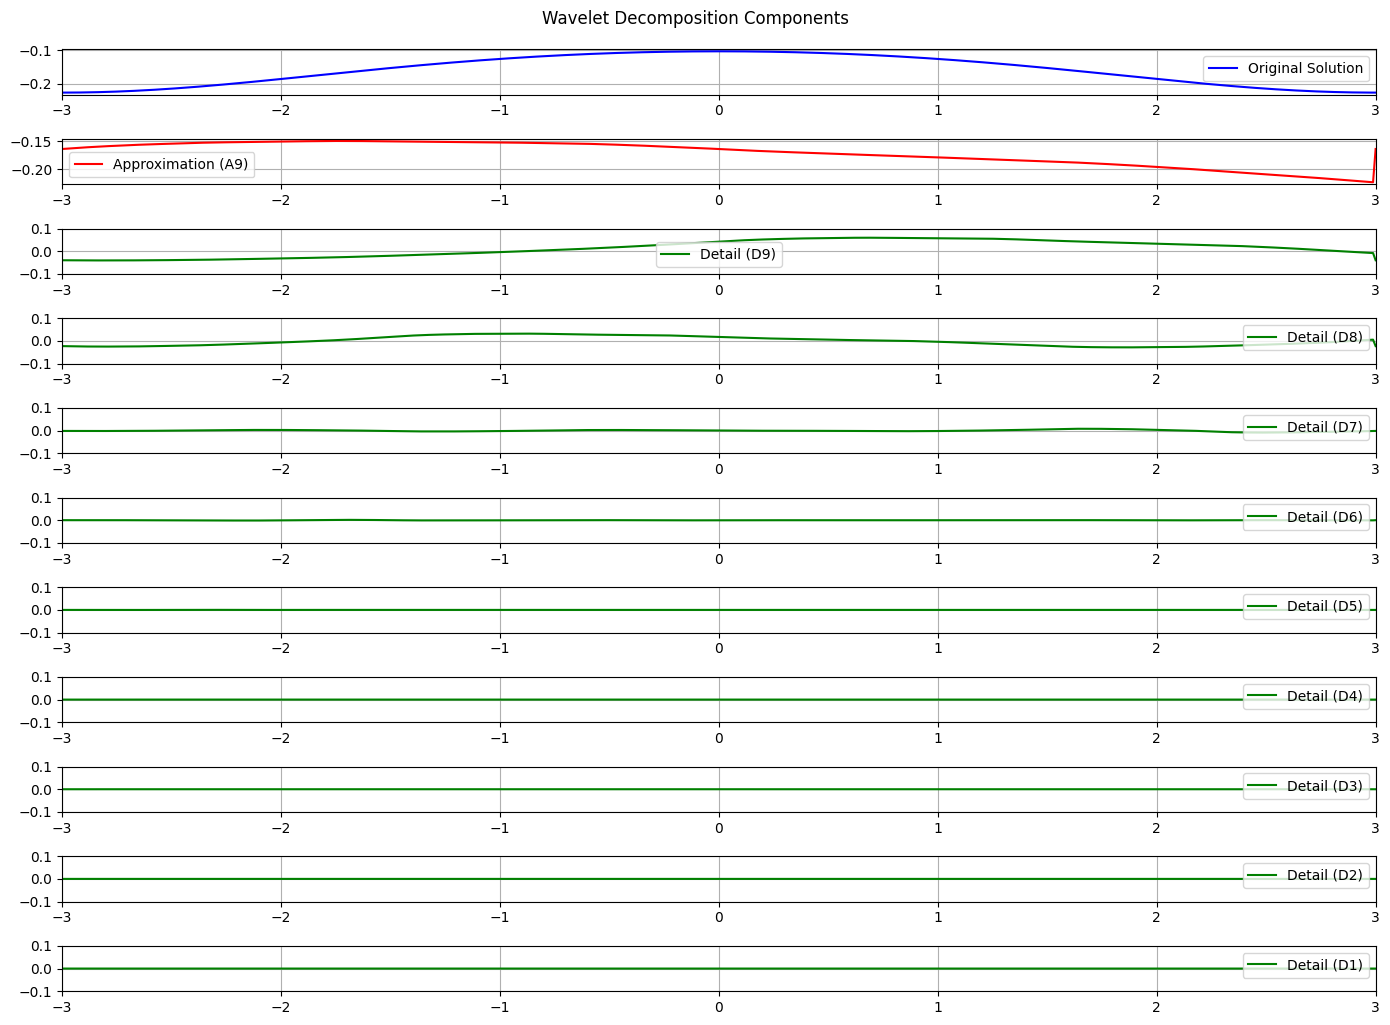

In [ ]:
# Application of wavelet in IEFE problems
# Advanced Engineering Mathematics
# First project
# Mohammad Mahdi Elyasi
# 403123091
# Prof. Moradi
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

# Parameters
ro0 = 1
ro1 = -1
n = 512
h = 2 * np.pi / n
a = 1
d = 10
wavelet = 'db4'
level = int(np.log2(n))  # Level = 9 for n=512

# Pre-computations
I = 4 * (np.log(2) * np.sin(h / 2) + 2 * (np.sin(h / 2) * np.log(np.sin(h / 2)) - np.sin(h / 2)))
B = a * np.log(a) - a / 2 * np.log(2 * a**2)
A = 2 * h * B

# Initialize arrays
teta = np.zeros(n)
f = np.zeros(n)
k = np.zeros(n)
mat = np.zeros((n, n))

# Calculate teta, f, and k
for i in range(n):
    teta[i] = i * h
    f[i] = ro0 * (np.log(d) - 0.5 * np.log(a**2 + d**2 - 2 * a * d * np.cos(teta[i])))

    if i == 0:
        k[i] = A - a / 2 * I
    else:
        k[i] = B - a / 2 * (np.log(2 * np.sin(teta[i] / 2)))
        if i == 1 or i == n - 1:
            k[i] *= h / 3
        else:
            k[i] *= 2 * h / 3 * (1 + i % 2)

# Construct the matrix mat
for i in range(n):
    for j in range(n):
        mat[i, j] = k[(j - i + n) % n]

# Solve the system in the physical domain (MATLAB-like approach)
f_physical = -f
ros_physical = np.linalg.solve(mat, f_physical)

# Normalize and correct the solution
su_physical = np.sum(ros_physical)
ros_physical = -su_physical / n + ros_physical + ro1 / (2 * np.pi * a)

# Prepare for plotting
x = np.pi / 180 * (np.arange(1, n + 2) - n / 2 - 1)
ros_physical = np.append(ros_physical, ros_physical[0])

# Plot only the MATLAB-like solution
plt.plot(x, ros_physical, linewidth=2, label='MATLAB-like Solution')
plt.ylabel('Charge density')
plt.xlabel('theta (rad)')
plt.legend()
plt.title('MATLAB-like Solution')
plt.grid(True)
plt.show()

coeffs_f = pywt.wavedec(f, wavelet, level=level)
mat_wav = lil_matrix((n, n))
for i in range(n):
    row = mat[i, :]
    coeffs_row = pywt.wavedec(row, wavelet, level=level)
    mat_wav[i, :] = pywt.waverec(coeffs_row, wavelet)[:n]
mat_wav = csr_matrix(mat_wav)
c = spsolve(mat_wav, -f)  # Solve in wavelet space

# Reconstruct solution
coeffs_rho = pywt.wavedec(c, wavelet, level=level)
ros_wavelet = pywt.waverec(coeffs_rho, wavelet)[:n]

# Normalization
su_wavelet = np.sum(ros_wavelet)
ros_wavelet = -su_wavelet/n + ros_wavelet + ro1/(2*np.pi*a)

# --- Wavelet decomposition of solution ---
coeffs_ros = pywt.wavedec(ros_wavelet, wavelet, level=level)

# 1. Reconstruct Approximation (A9)
approx_coeffs = [coeffs_ros[0].copy()]
for i in range(1, len(coeffs_ros)):
    approx_coeffs.append(np.zeros_like(coeffs_ros[i]))
A = pywt.waverec(approx_coeffs, wavelet)[:n]

# 2. Reconstruct Details (D9 to D1)
D_components = []
for i in range(1, len(coeffs_ros)):
    detail_coeffs = [np.zeros_like(c) if j != i else coeffs_ros[i].copy() 
                    for j, c in enumerate(coeffs_ros)]
    D_i = pywt.waverec(detail_coeffs, wavelet)[:n]
    D_components.append(D_i)

# --- Plotting with shifted x-axis [-3, 3] ---
theta = np.linspace(0, 2*np.pi, n, endpoint=False)

# Shift and scale theta to [-3, 3]
theta_shifted = (theta - np.pi) * (3 / np.pi)  # Shift left by π and scale
theta_plot_shifted = np.append(theta_shifted, 3)  # Append 3 to match 2π

# Plot 1: Original Solution (shifted x-axis)
plt.figure(figsize=(10, 6))
ros_wavelet_plot = np.append(ros_wavelet, ros_wavelet[0])
plt.plot(theta_plot_shifted, ros_wavelet_plot, '--', linewidth=2, label='Wavelet Solution')
plt.xlim(-3, 3)  # Enforce x-axis limits
plt.title('Wavelet-based Charge Density Solution')
plt.xlabel('Theta (rad)')
plt.ylabel('Charge Density')
plt.legend()
plt.grid(True)

# Plot 2: Decomposition Components (shifted x-axis)
plt.figure(figsize=(14, 10))

# Original signal
plt.subplot(level+2, 1, 1)
plt.plot(theta_plot_shifted, ros_wavelet_plot, 'b', label='Original Solution')
plt.xlim(-3, 3)
plt.legend()
plt.grid(True)

# Approximation
plt.subplot(level+2, 1, 2)
A_plot = np.append(A, A[0])
plt.plot(theta_plot_shifted, A_plot, 'r', label=f'Approximation (A{level})')
plt.xlim(-3, 3)
plt.legend()
plt.grid(True)

# Details
for idx, D_i in enumerate(D_components):
    plt.subplot(level+2, 1, idx+3)
    D_plot = np.append(D_i, D_i[0])
    plt.plot(theta_plot_shifted, D_plot, 'g', label=f'Detail (D{level - idx})')
    plt.ylim(-0.1, 0.1)  # Existing y-limit for details
    plt.xlim(-3, 3)  # New x-limit
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Wavelet Decomposition Components', y=1.02)
plt.show()
